In [13]:
import math
import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Markdown
from glob2 import glob

PATH = 'data'

In [14]:
data = np.array([cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB) for p in glob(f'{PATH}/*')])
data.shape

<ipython-input-14-fb827623fb61>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array([cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB) for p in glob(f'{PATH}/*')])


(4,)

In [15]:
# Gaussian Function:
def G(x, mean, std):
    return np.exp(-0.5*np.square((x-mean)/std))

# Membership Functions:
def ExtremelyDark(x, M):
    return G(x, -50, M/6)

def VeryDark(x, M):
    return G(x, 0, M/6)

def Dark(x, M):
    return G(x, M/2, M/6)

def SlightlyDark(x, M):
    return G(x, 5*M/6, M/6)

def SlightlyBright(x, M):
    return G(x, M+(255-M)/6, (255-M)/6)

def Bright(x, M):
    return G(x, M+(255-M)/2, (255-M)/6)

def VeryBright(x, M):
    return G(x, 255, (255-M)/6)

def ExtremelyBright(x, M):
    return G(x, 305, (255-M)/6)

In [16]:
def OutputFuzzySet(x, f, M, thres):
    x = np.array(x)
    result = f(x, M)
    result[result > thres] = thres
    return result

def AggregateFuzzySets(fuzzy_sets):
    return np.max(np.stack(fuzzy_sets), axis=0)

def Infer(i, M, get_fuzzy_set=False):
    # Calculate degree of membership for each class
    VD = VeryDark(i, M)
    Da = Dark(i, M)
    SD = SlightlyDark(i, M)
    SB = SlightlyBright(i, M)
    Br = Bright(i, M)
    VB = VeryBright(i, M)
    
    # Fuzzy Inference:
    x = np.arange(-50, 306)
    Inferences = (
        OutputFuzzySet(x, ExtremelyDark, M, VD),
        OutputFuzzySet(x, VeryDark, M, Da),
        OutputFuzzySet(x, Dark, M, SD),
        OutputFuzzySet(x, Bright, M, SB),
        OutputFuzzySet(x, VeryBright, M, Br),
        OutputFuzzySet(x, ExtremelyBright, M, VB)
    )
    
    # Calculate AggregatedFuzzySet:
    fuzzy_output = AggregateFuzzySets(Inferences)
    
    # Calculate crisp value of centroid
    if get_fuzzy_set:
        return np.average(x, weights=fuzzy_output), fuzzy_output
    return np.average(x, weights=fuzzy_output)

In [17]:
# Proposed fuzzy method
def FuzzyContrastEnhance(rgb):
    # Convert RGB to LAB
    lab = cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)
    print("lab: ",lab)
    # Get L channel
    l = lab[:, :, 0]

    # print("L:",l)
    
    # Calculate M value
    M = np.mean(l)
    if M < 128:
        M = 127 - (127 - M)/2
    else:
        M = 128 + M/2

    # print("M: ",M)
        
    # Precompute the fuzzy transform
    x = list(range(-50,306))
    FuzzyTransform = dict(zip(x,[Infer(np.array([i]), M) for i in x]))
    print( FuzzyTransform)
    
    # Apply the transform to l channel
    u, inv = np.unique(l, return_inverse = True)
    
    print("new u: ",u)
    print("new inv: ",inv)
    l = np.array([FuzzyTransform[i] for i in u])[inv].reshape(l.shape)

    print("new L: ",l)
    
    
    # Min-max scale the output L channel to fit (0, 255):
    Min = np.min(l)
    Max = np.max(l)
    lab[:, :, 0] = (l - Min)/(Max - Min) * 255
    print("new Lab: ",lab)
    
    # Convert LAB to RGB
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
#     return lab

# Traditional method of histogram equalization
def HE(rgb):
    lab = cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)
    lab[:, :, 0] = cv2.equalizeHist(lab[:, :, 0])
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

# Contrast Limited Adaptive Histogram Equalization
def CLAHE(rgb):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    lab = cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)
    lab[:, :, 0] = clahe.apply(lab[:, :, 0])
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

lab:  [[[175 129 117]
  [175 130 117]
  [175 129 117]
  ...
  [ 95 130 115]
  [ 95 130 115]
  [ 93 131 115]]

 [[176 128 117]
  [176 129 117]
  [175 130 117]
  ...
  [ 94 130 115]
  [ 92 130 115]
  [ 92 130 115]]

 [[175 129 117]
  [174 129 117]
  [173 129 117]
  ...
  [ 92 130 115]
  [ 92 130 115]
  [ 92 130 115]]

 ...

 [[102 130 116]
  [102 130 116]
  [103 129 116]
  ...
  [ 54 133 120]
  [ 53 132 122]
  [ 50 132 120]]

 [[102 130 116]
  [103 130 116]
  [102 129 116]
  ...
  [ 56 132 122]
  [ 53 132 122]
  [ 49 131 121]]

 [[103 130 116]
  [103 130 116]
  [102 129 116]
  ...
  [ 56 133 122]
  [ 54 133 122]
  [ 50 132 121]]]
{-50: -21.0752055565827, -49: -21.497011740649008, -48: -21.91603535359228, -47: -22.33213757923875, -46: -22.745171035268335, -45: -23.154979168383097, -44: -23.561395604121042, -43: -23.964243448160957, -42: -24.36333453586241, -41: -24.75846862671803, -40: -25.149432540376512, -39: -25.535999230942394, -38: -25.91792679639335, -37: -26.29495742020699, -36: -2

new inv:  [170 170 170 ...  51  49  45]
new L:  [[228.0445443  228.0445443  228.0445443  ...  58.21987531  58.21987531
   53.72995574]
 [229.1353801  229.1353801  228.0445443  ...  55.93858133  51.60287395
   51.60287395]
 [228.0445443  226.93773201 225.81286744 ...  51.60287395  51.60287395
   51.60287395]
 ...
 [ 75.79196368  75.79196368  78.43075567 ...   6.24903579   5.72697104
    4.39827642]
 [ 75.79196368  78.43075567  75.79196368 ...   7.41950566   5.72697104
    4.02162245]
 [ 78.43075567  78.43075567  75.79196368 ...   7.41950566   6.24903579
    4.39827642]]
new Lab:  [[[208 129 117]
  [208 130 117]
  [208 129 117]
  ...
  [ 72 130 115]
  [ 72 130 115]
  [ 68 131 115]]

 [[209 128 117]
  [209 129 117]
  [208 130 117]
  ...
  [ 70 130 115]
  [ 66 130 115]
  [ 66 130 115]]

 [[208 129 117]
  [207 129 117]
  [206 129 117]
  ...
  [ 66 130 115]
  [ 66 130 115]
  [ 66 130 115]]

 ...

 [[ 86 130 116]
  [ 86 130 116]
  [ 88 129 116]
  ...
  [ 30 133 120]
  [ 30 132 122]
  [ 28 132

### <p style="text-align: center;">Sample Photo 1</p>

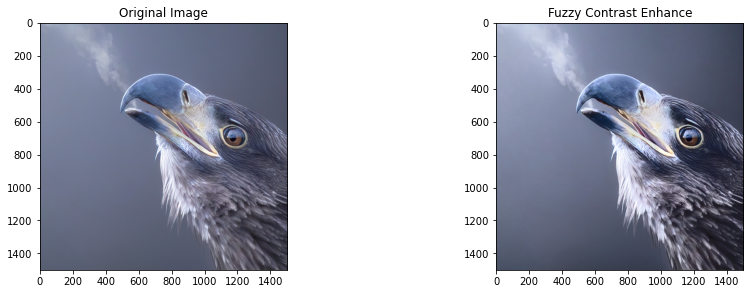

lab:  [[[225 128 123]
  [225 128 123]
  [225 128 123]
  ...
  [205 128 122]
  [200 129 122]
  [198 129 122]]

 [[225 128 123]
  [225 128 123]
  [225 128 123]
  ...
  [210 128 122]
  [217 129 122]
  [204 129 122]]

 [[225 128 123]
  [225 128 123]
  [225 128 123]
  ...
  [197 129 122]
  [202 129 122]
  [227 129 122]]

 ...

 [[230 128 125]
  [230 128 125]
  [230 128 125]
  ...
  [226 128 124]
  [226 130 124]
  [227 129 124]]

 [[230 128 125]
  [230 128 125]
  [230 128 125]
  ...
  [225 128 124]
  [225 129 124]
  [226 130 124]]

 [[230 128 125]
  [230 128 125]
  [230 128 125]
  ...
  [225 128 124]
  [225 129 124]
  [226 130 124]]]
{-50: -13.097267210713882, -49: -13.410598800189938, -48: -13.719103181635713, -47: -14.022628847306764, -46: -14.321019835933384, -45: -14.614115709796922, -44: -14.9017515487044, -43: -15.183757963421494, -42: -15.4599611313923, -41: -15.730182857861323, -40: -15.994240665819284, -39: -16.25194791851822, -38: -16.50311397864191, -37: -16.74754440857335, -36: -

### <p style="text-align: center;">Sample Photo 2</p>

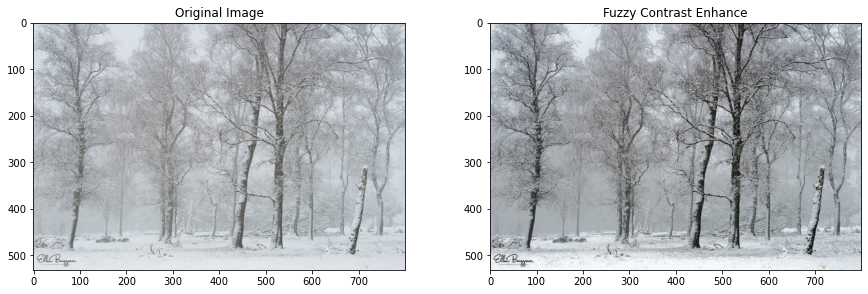

lab:  [[[198 125 119]
  [197 125 119]
  [197 125 119]
  ...
  [197 126 119]
  [197 126 119]
  [197 126 119]]

 [[197 125 119]
  [197 125 119]
  [197 125 119]
  ...
  [197 126 119]
  [197 126 119]
  [197 126 119]]

 [[197 125 119]
  [196 125 119]
  [196 125 119]
  ...
  [197 126 119]
  [197 126 119]
  [197 126 119]]

 ...

 [[145 129 121]
  [145 129 121]
  [151 129 121]
  ...
  [206 125 119]
  [205 125 119]
  [208 125 119]]

 [[130 129 121]
  [152 129 121]
  [159 129 121]
  ...
  [199 125 119]
  [199 125 119]
  [201 125 119]]

 [[137 129 122]
  [145 129 122]
  [152 129 122]
  ...
  [193 125 119]
  [193 125 119]
  [194 125 119]]]
{-50: -12.19760300679354, -49: -12.501310293193601, -48: -12.800102847374419, -47: -13.093833845935544, -46: -13.382352568959288, -45: -13.665504415415421, -44: -13.943130936872123, -43: -14.215069891942107, -42: -14.481155324120289, -41: -14.741217665909511, -40: -14.995083872382732, -39: -15.242577587593004, -38: -15.483519347513832, -37: -15.717726823469997, 

### <p style="text-align: center;">Sample Photo 3</p>

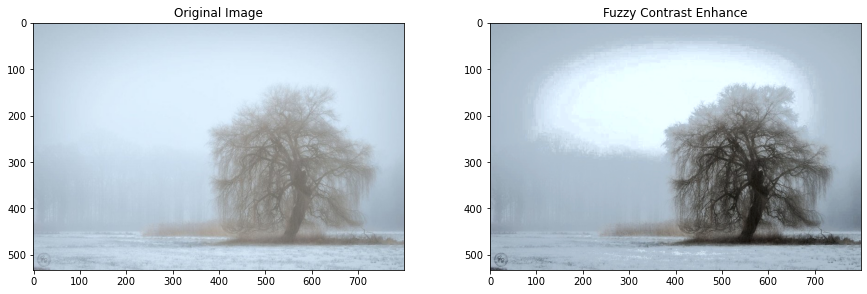

lab:  [[[ 15 122 136]
  [ 16 122 137]
  [ 16 122 137]
  ...
  [ 54 118 152]
  [ 55 117 152]
  [ 56 117 151]]

 [[ 16 122 137]
  [ 16 122 137]
  [ 16 122 137]
  ...
  [ 55 117 152]
  [ 56 117 151]
  [ 57 118 151]]

 [[ 16 122 137]
  [ 16 122 137]
  [ 17 122 137]
  ...
  [ 56 117 151]
  [ 57 118 151]
  [ 58 118 152]]

 ...

 [[ 58 115 148]
  [ 58 115 148]
  [ 58 115 148]
  ...
  [ 76 115 155]
  [ 75 115 155]
  [ 73 115 154]]

 [[ 59 116 148]
  [ 59 116 148]
  [ 61 115 148]
  ...
  [ 76 115 155]
  [ 74 115 154]
  [ 73 115 154]]

 [[ 59 116 148]
  [ 61 115 148]
  [ 61 115 148]
  ...
  [ 76 115 155]
  [ 74 115 154]
  [ 72 115 154]]]
{-50: -22.0812481183014, -49: -22.52047036639578, -48: -22.957429779633095, -47: -23.392006027749233, -46: -23.824070690294388, -45: -24.253486614998973, -44: -24.680107218826173, -43: -25.103775726479952, -42: -25.524324340363226, -41: -25.94157333557018, -40: -26.355330072668384, -39: -26.76538792082882, -38: -27.171525083187223, -37: -27.573503315320288, -36:

### <p style="text-align: center;">Sample Photo 4</p>

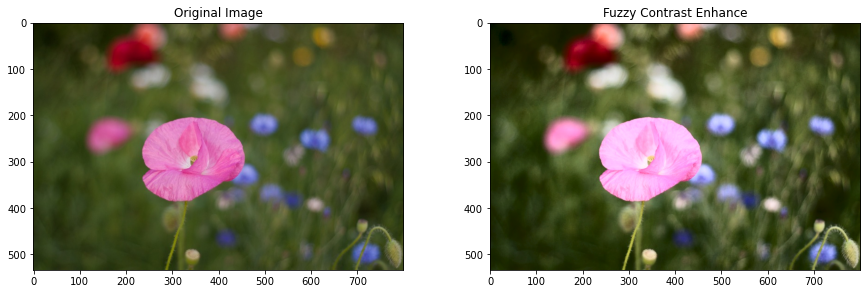

In [18]:
for i in range(data.shape[0]):
    img = data[i]
    fce = FuzzyContrastEnhance(img)
    he = HE(img)
    clahe = CLAHE(img) 
    display(Markdown(f'### <p style="text-align: center;">Sample Photo {i+1}</p>'))
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, 1)
    plt.imshow(data[i])
    plt.title('Original Image')
    
    plt.subplot(2, 2, 2)
    plt.imshow(fce)
    plt.title('Fuzzy Contrast Enhance')
    
    # plt.subplot(2, 2, 3)
    # plt.imshow(he)
    # plt.title('Traditional HE')
    
    # plt.subplot(2, 2, 4)
    # plt.imshow(clahe)4
    # plt.title('CLAHE')
    
    plt.show()

In [ ]:

0
